In [1]:
#  Reward function shaping in this script -- no terminal reward

In [2]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle

In [3]:
df_train = pd.read_csv('../data/rl_train_set_scaled.csv')
df_val =  pd.read_csv('../data/rl_val_set_scaled.csv')
df_test = pd.read_csv('../data/rl_test_set_scaled.csv')

In [4]:
# df_train_disc = pd.read_csv('../data/rl_train_data_discrete.csv')
# df_val_disc = pd.read_csv('../data/rl_val_data_discrete.csv')
# df_test_disc = pd.read_csv('../data/rl_test_data_discrete.csv')

In [5]:
df_train.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,0
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,0
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,0


In [6]:
len(df_train)

169495

In [7]:
df_test.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,33,7214126400,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.883180,0.838839,0.834329,0.776672,0.585147,0.0,4.0,0
1,0.222560,33,7214140800,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.888664,0.848773,0.839133,0.797009,0.592405,0.0,4.0,0
2,0.356608,33,7214155200,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.894069,0.854142,0.842937,0.779852,0.601449,0.0,4.0,0
3,0.452837,33,7214169600,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.898397,0.839183,0.845526,0.746598,0.609910,0.0,4.0,0
4,0.527957,33,7214184000,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.901804,0.821399,0.848365,0.758993,0.615787,0.0,4.0,0


In [9]:
# Clear existing rewards
df_train['reward'] = 0
df_val['reward'] = 0
df_test['reward'] = 0

In [10]:
orig_df = pd.read_csv('../data/MKdataset07Feb17.csv')

In [11]:
# lactate - target is 0.5 to 1 mmol/l
# SOFA - 0
#  GCS - 0
#  mechvent = 0
# MAP is normally between 65 and 110 mmHg

In [12]:
# s1 = orig_df['SOFA'].values
# s2 = orig_df['SOFA'].values
# s2 = np.insert(s2,0,9)
# s2 = np.delete(s2, -1)
# print len(s1), len(s2)

In [13]:
# pd.Series(s2-s1).hist(bins=100)

In [14]:
# l1 = orig_df['Arterial_lactate'].values
# l2 = orig_df['Arterial_lactate'].values
# l2 = np.insert(l2,0,9)
# l2 = np.delete(l2, -1)
# print len(l1), len(l2)

In [25]:
c0 = -0.25
c1 = -0.75
c2 = -0.5

In [26]:
# c0 = -0.1/2
# c1 = -0.5/2
# c2 = -2

In [27]:
# add rewards
orig_df['shaped_reward'] = 0
for i in orig_df.index:
    if i == 0:
        continue
    if orig_df.loc[i, 'icustayid'] == orig_df.loc[i-1, 'icustayid']:
        sofa_cur = orig_df.loc[i,'SOFA']
        sofa_prev = orig_df.loc[i-1,'SOFA']
        lact_cur = orig_df.loc[i,'Arterial_lactate']
        lact_prev = orig_df.loc[i-1,'Arterial_lactate']
        reward = 0
        if sofa_cur == sofa_prev and sofa_cur != 0:
            reward += c0
        reward += c1*(sofa_cur-sofa_prev)
        reward += c2*np.tanh(lact_cur - lact_prev)
        orig_df.loc[i-1,'shaped_reward'] = reward
    if i % 10000 == 0:
        print(i)

# if orig_df.ix[len(orig_df)-1, 'died_in_hosp'] == 1:
#     orig_df.ix[len(orig_df)-1, 'shaped_reward'] = -100
# elif orig_df.ix[len(orig_df)-1, 'died_in_hosp'] == 0:
#      orig_df.ix[len(orig_df)-1, 'shaped_reward'] = 100
print(orig_df['shaped_reward'].value_counts())

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
-0.250000    26568
 0.000000    18459
 0.750000     8824
-0.750000     8061
 1.500000     3221
-1.500000     2777
 2.250000     2112
 3.000000     1953
-2.250000     1431
-3.000000      966
 3.750000      511
-0.299834      448
-0.200166      441
-0.259999      426
-0.274979      412
-0.225021      374
-0.230011      353
-0.240001      314
-3.750000      293
-0.262497      249
-0.233340      237
-0.237503      230
-0.266660      230
-0.269989      230
-0.243750      218
-0.348688      207
 0.799834      205
 0.700166      197
-0.200166      192
-0.324443      181
             ...  
-1.002336        1
-0.717822        1
 0.019989        1
 0.711839        1
 1.438943        1
-0.749117        1
 0.397216        1
-0.266106        1
-0.215843        1
-0.908124        1
-0.843337        1
-0.344103        1
-0.950682        1
-1.50

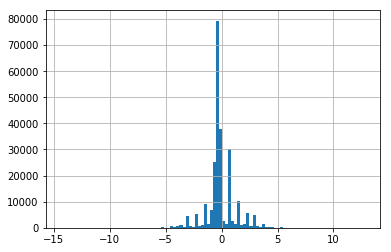

In [28]:
%matplotlib inline
orig_df['shaped_reward'].hist(bins=100)

In [32]:
train_ids = df_train['icustayid'].unique()
val_ids = df_val['icustayid'].unique()
test_ids = df_test['icustayid'].unique()

In [33]:
train_rewards = orig_df.loc[orig_df['icustayid'].isin(train_ids)]['shaped_reward']

In [34]:
len(train_rewards)

169495

In [35]:
train_rewards.tail()

242432   -0.271415
242433   -0.271415
242434    0.728585
242435   -0.271415
242436    0.000000
Name: shaped_reward, dtype: float64

In [36]:
# check this works as expected
val_rewards = orig_df.loc[orig_df['icustayid'].isin(val_ids)]['shaped_reward']

In [37]:
test_rewards = orig_df.loc[orig_df['icustayid'].isin(test_ids)]['shaped_reward']

In [38]:
len(test_rewards)

48617

In [39]:
len(val_rewards)

24338

In [40]:
len(orig_df)

242450

In [41]:
df_train.tail()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
169490,0.923625,99994,4574226420,1.0,0.766044,0.428571,1.0,0,0,0.284407,...,0.0,0.0,0.931448,0.500469,0.0,0.0,0.838953,0.0,1.0,0
169491,0.944365,99994,4574240820,1.0,0.766044,0.428571,1.0,0,0,0.284407,...,0.0,0.0,0.931541,0.521433,0.0,0.0,0.839369,0.0,1.0,0
169492,0.963927,99994,4574255220,1.0,0.766044,0.428571,1.0,0,0,0.284407,...,0.0,0.0,0.931616,0.500469,0.0,0.0,0.839703,0.0,1.0,0
169493,0.982436,99994,4574269620,1.0,0.766044,0.428571,1.0,0,0,0.284407,...,0.0,0.0,0.931691,0.500469,0.0,0.0,0.840036,0.0,1.0,0
169494,1.000000,99994,4574284020,1.0,0.766044,0.428571,1.0,0,0,0.284407,...,0.0,0.0,0.931765,0.500469,0.0,0.0,0.840369,0.0,1.0,0


In [42]:
len(orig_df['shaped_reward'])

242450

In [43]:
len(df_train)

169495

In [44]:
# check that this sums to the total number of data items -- needs to be re-run
len(df_train) + len(df_test) + len(df_val)

242450

In [45]:
df_train['reward'] += np.array(train_rewards)
df_val['reward'] += np.array(val_rewards)
df_test['reward'] += np.array(test_rewards)

In [46]:
# df_train_disc['reward'] += np.array(train_rewards)
# df_val_disc['reward'] += np.array(val_rewards)
# df_test_disc['reward'] += np.array(test_rewards)

In [47]:
df_train.to_csv('../data/rl_train_data_final_cont_noterm.csv',index=False)
df_val.to_csv('../data/rl_val_data_final_cont_noterm.csv', index=False)
df_test.to_csv('../data/rl_test_data_final_cont_noterm.csv',index=False)

In [37]:
# df_train_disc.to_csv('../data/rl_train_data_final_disc.csv',index=False)
# df_val_disc.to_csv('../data/rl_val_data_final_disc.csv', index=False)
# df_test_disc.to_csv('../data/rl_test_data_final_disc.csv',index=False)

In [38]:
train_rewards.head(n=20)

0     0.125000
1     0.657321
2     1.367788
3     1.199099
4     1.057596
5    -0.625000
6     0.432822
7     1.905144
8    -0.375000
9     0.054957
10    0.054957
11    0.054957
12    0.054957
13    0.000000
14    0.125000
15   -0.144856
16   -0.104957
17   -0.625000
18    0.250000
19   -0.025000
Name: shaped_reward, dtype: float64

In [39]:
df_train['reward'].head(n=20)

0      0.125000
1      0.657321
2      1.367788
3      1.199099
4      1.057596
5     -0.625000
6      0.432822
7      1.905144
8     -0.375000
9      0.054957
10     0.054957
11     0.054957
12     0.054957
13    15.000000
14     0.125000
15    -0.144856
16    -0.104957
17    -0.625000
18     0.250000
19    -0.025000
Name: reward, dtype: float64